# GS541 phylogenetics homework 1

## Poisson distribution and estimation via maximum likelihood

At the end of this segment, I hope you understand:

* why we use the Poisson distribution to model mutation processes
* how we perform model parameter estimation via maximum likelihood

We will use the [pandas](https://pandas.pydata.org/docs/user_guide/index.html) package for data analysis.
If you aren't familiar with it, it's a great thing to know and I hope these homeworks serve as a useful introduction.

In [1]:
from scipy.stats import bernoulli, poisson

import numpy as np
import pandas as pd
import random

_Exercise: using either the built-in [random](https://docs.python.org/3/library/random.html) module, or the [SciPy bernoulli class](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.bernoulli.html), write code for the following function according to the docstring._

In [2]:
def sample_event(probability):
    """Return 1 with probability `probability`, otherwise return 0."""
    return bernoulli.rvs(probability)

Demonstrate that your code is working properly by summing together a large number of outputs from this function and seeing that it's giving (approximately) the expected number of 1s.

In [3]:
sum([sample_event(0.275) for i in range(10000)])/10000

0.2832

Let's write a function to count mutations:

In [4]:
def count_mutations(generation_count, mutation_probability):
    """Simulate the total number of mutations after `generation_count` generations, 
    each of which may lead to a muatation with probability `mutation_probability`."""
    return np.sum(np.random.rand(generation_count) < mutation_probability)

_Try this function a few times._

In [5]:
count_mutations(100, 0.275)

35

Now imagine we have a highly mutable stretch of DNA 10,000 bases long. 
Say this evolves for 700 generations, and each generation each site has a probability of 0.005 of being mutated.
Let's simulate the number of mutations for each site of the stretch of DNA:

In [6]:
mutation_counts = pd.Series([count_mutations(700, 0.005) for i in range(10000)])

<Axes: ylabel='Frequency'>

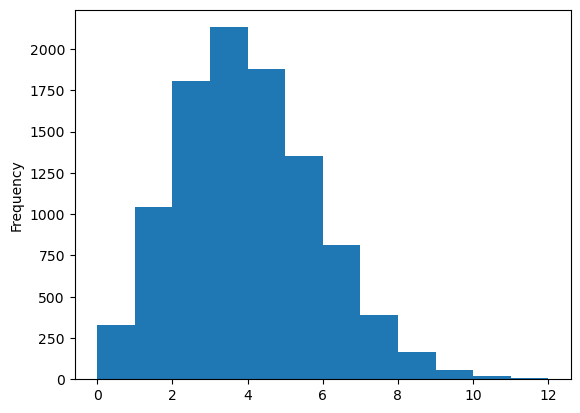

In [7]:
mutation_counts.plot.hist(bins=max(mutation_counts))

This distribution looks [Poisson-distributed](https://en.wikipedia.org/wiki/Poisson_distribution) (in fact, [we know that it should be almost exactly Poisson](https://en.wikipedia.org/wiki/Poisson_distribution#Law_of_rare_events)).
So let's model it accordingly. 
Try out various parameters for sampling from the [Poisson distribution as implemented in SciPy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.poisson.html).

In [8]:
poisson.rvs(4., size=20)

array([5, 7, 2, 4, 4, 3, 4, 5, 4, 7, 0, 3, 3, 5, 5, 0, 3, 4, 2, 5])

Note that we've now moved from a parameterization in terms of a discrete number of generations to a continuous one in terms of the mean of a Poisson distribution.

_Exercise: try out a couple of values for the Poisson mean `pois_parameter` below and see if you can find a value such that the Poisson distribution matches the simulated data._

<Axes: ylabel='Frequency'>

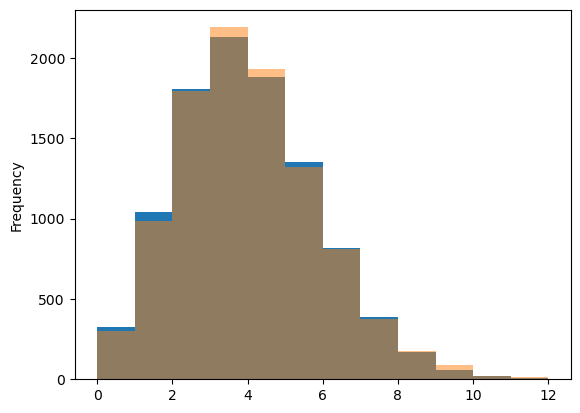

In [9]:
ax = mutation_counts.plot.hist(bins=max(mutation_counts))

pois_parameter = 3.55
pois_samples = poisson.rvs(pois_parameter, size=10000)
pd.Series(pois_samples).plot.hist(bins=max(pois_samples), ax=ax, alpha=0.5)

Before we continue, take a moment and reflect what we are doing: we are choosing a parameter value for our _model_ such that when we simulate values from that model, they match (as best as possible) the observed data.

This is the essence of [maximum likelihood inference](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation): choosing parameter values for a model such that the model is as likely as possible to generate the observed data.

Now we're going to do such estimation more formally.

The basic insight is that if our model is simple enough we don't have to _simulate_ in order to match the simulated and observed data, but we can just _calculate_ likelihoods directly. 

Let's look at the Probability Mass Function for the Poisson distribution.

In [10]:
poisson.pmf(4, 2.5)

0.13360188578108528

This says that the probability of getting 4 from a Poission distribution with mean 2.5 is about 0.13.

_Exercise: read up about the [Poisson distribution](https://en.wikipedia.org/wiki/Poisson_distribution#Probability_mass_function) and code up your own version of the probability mass function for 4 mutations and varying Poisson mean parameter. Check that it matches the SciPy version `poisson` that we've been using._

In [11]:
def poisson_pmf(k, mu):
    return mu**k * np.exp(-mu) / np.math.factorial(k)

poisson_pmf(4, 2.5)

0.13360188578108528

We can plot the corresponding distribution, which gives the probability of generating 4 mutations from a Poisson process with various means:

<Axes: xlabel='x'>

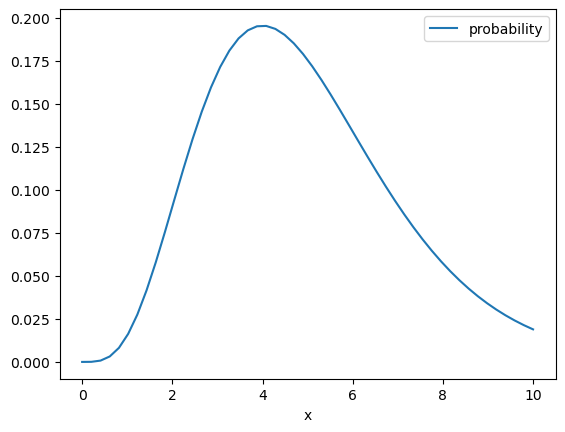

In [12]:
x_values = np.linspace(0., 10.)
probabilities = poisson.pmf(4, x_values)
pd.DataFrame({"x": x_values, "probability": probabilities}).plot(x="x", y="probability")

_Exercise: what value maximizes the likelihood in this plot? Why is that value not surprising?_

4 - it is the mean of the Poisson distribution

Now let's say that we have two sites, and mutations arise in these two sites independently. 
By this independence assumption, [the probability of a particular observation at these two sites is the product of the probabilities at each site](https://en.wikipedia.org/wiki/Independence_%28probability_theory%29#Two_events).

So, if we have a Poisson distribution with mean 2.5 as before, the probability of getting 4 mutations in one site and then 7 mutations in another is:

In [13]:
poisson.pmf(4, 2.5) * poisson.pmf(7, 2.5)

0.0013280851104361725

_Exercise: make the same plot as just above, but rather than just for one site with 4 mutations, we now have one site with 4 mutations and one site with 7 mutations. What value maximizes the likelihood now (approximately)?_

<Axes: xlabel='x'>

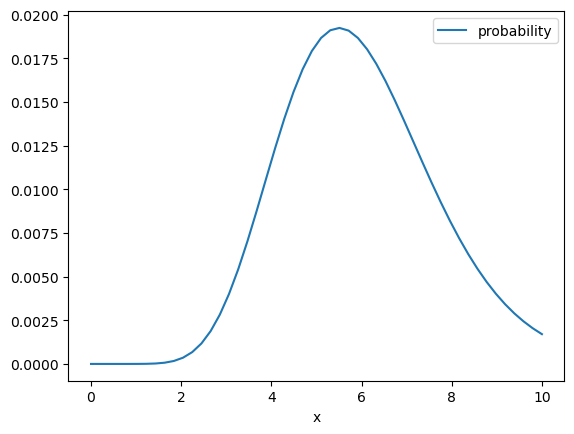

In [14]:
x_values = np.linspace(0., 10.)
probabilities = poisson.pmf(4, x_values) * poisson.pmf(7, x_values)
pd.DataFrame({"x": x_values, "probability": probabilities}).plot(x="x", y="probability")

About 5.5

Now we'd like to extend this to many sites, say the 10,000 sites we simulated above. But we encounter a problem!

In [15]:
np.prod(poisson.pmf(mutation_counts, 3.))

0.0

_Exercise: what problem did we encounter?_

underflow

We can avoid this problem by taking the log probability of each observation and then summing to get the log likelihood of the whole data set:

In [16]:
np.sum(poisson.logpmf(mutation_counts, 3.))

-20607.97663074657

Because log is monotonically increasing, finding the maximum of the log of a function gives the same value as maximizing the function itself.

_Exercise: fill in the missing line of code below so that the code block plots the log likelihood for observing `mutation_counts` under a Poisson model._

<Axes: xlabel='x'>

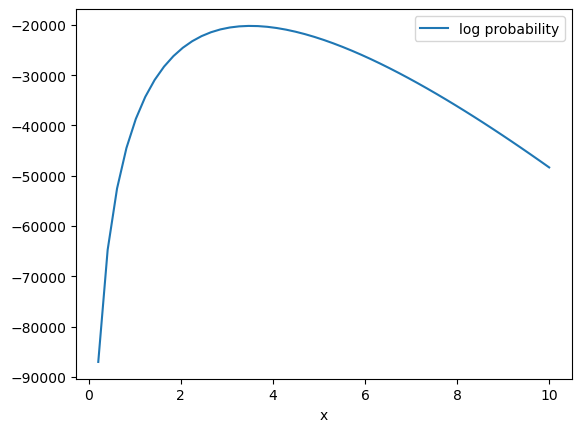

In [17]:
x_values = np.linspace(0., 10.)
log_probabilities = np.array([np.sum(poisson.logpmf(mutation_counts, x)) for x in x_values])
pd.DataFrame({"x": x_values, "log probability": log_probabilities}).plot(x="x", y="log probability")

_Exercise: what is the maximum likelihood value of the parameter of the Poisson distribution we are using? Why is this not surprising?_

3 - it is the mean

_Exercise: describe the connection between simulation and likelihoods that we explored in this segment._

simulations reflect and can be used to estimate likelihood  

## Simulating sequence models

At the end of this segment, I hope you understand:

* Why we can't just "count mutations" in a straightforward way
* The difference between "mutations" and "substitutions"

We'll start by thinking in terms of discrete events.

Let's imagine that instead of a 4-state alphabet `A, G, C, T` we have just two states, 0 and 1. Here's an example [probability transition matrix](https://en.wikipedia.org/wiki/Stochastic_matrix) that we might use to model probability of substitution after some large number $N$ of generations:

In [18]:
a = np.matrix([[0.9, 0.1],[0.1, 0.9]])
a

matrix([[0.9, 0.1],
        [0.1, 0.9]])

The states here are lined up on the rows and the columns, so the 0,0 entry corresponds to the probability of a site in state 0 ending in state 0 after $N$ generations, whereas the 0.1 corresponds to ending in state 1 after $N$ generations. If we want the process after $2N$ generations, then we take the matrix product of the two matrices to get the corresponding probability transition matrix:

In [19]:
a @ a

matrix([[0.82, 0.18],
        [0.18, 0.82]])

_Exercise: justify the calculation of the 0,0 entry of this matrix in terms of the formula for the matrix product. I suggest starting with: "There are two ways that one can start in state 0 and end in state 0 in two steps. One can either..."_

There are two ways that one can start in state 0 and end in state 0 in two steps. One can either start in state 0 and end in state 0 for one step, then start in state 0 and end in state 0 in another step. Or, one can start in state 0 and end in state 1 in one step, then start in state 1 and end in state 0 in one step. The probability of the first is 0.9*0.9 = 0.81. The probability of the second is 0.1 * 0.1 = 0.01. The sum of these is 0.82.

_Exercise: given this, why can't we simply "count mutations" in a straightforward way?_

we don't know how many generations it took to get from one state to another

_Exercise: use `np.linalg.matrix_power` to take high powers of this matrix. 
What does that tell you about the long-run behavior of this process?_

In [20]:
np.linalg.matrix_power(a, 100)

matrix([[0.5, 0.5],
        [0.5, 0.5]])

the process converges to a steady state

Although this discrete perspective is useful, it's not the foundation for likelihood-based phylogenetics. 
One problem is that if we are going to have a high level of resolution for the "number of events" that has happened, the effect of these events has to be very small.
Perhaps a more practical reason is that estimating a continuous quantity is just easier than estimating a discrete quantity, and is more suitable for methods using gradients.

Thus, how do we work in continuous time?
In the previous section, we saw how we can use the Poisson distribution to model the number of mutations after a certain (continuous) period. 
In this section, we will use this perspective and think of mutations accumulating in continuous time according to a certain rate.
Specifically, the number of mutations will be Poisson distributed with mean equal to the rate $\mu$ times time $t$.

To go from a general description of "events" to the impact of those events on sequences, we need to define what happens when a sequence is mutated. 
Let's say that, in our binary alphabet, once a mutation happens, it's replaced with a uniformly selected base from the 0,1 alphabet.
**This is important: not every mutation event will result in a state change.**
This is the difference between a "mutation" and a "substitution": a substitution is a mutation that results in a state change (not all mutations do).

_Exercise: if $\mu$ is the per-site mutation rate for the above-described substitution process, what is the per-site substitution rate?_

mu

_Exercise: write a routine `number_of_ones_after_time` that simulates sequence evolution for a 0,1 alphabet for $\mu=1$. Specifically, the routine should start with an all-0s sequence of length `sequence_length`, simulate sequence evolution for time `t` with $\mu=1$ and return the number of 1s in the resulting sequence. (Note that your code doesn't have to explicitly represent sequences in this way as long as it returns the desired result.)_

In [21]:
def number_of_ones_after_time(t, sequence_length):
    sequence = np.zeros(sequence_length)
    mutation_count = np.random.poisson(t, size=sequence_length)
    for i in range(sequence_length):
        for _ in range(mutation_count[i]):
            position = np.random.randint(sequence_length)
            sequence[position] = 1 - sequence[position]
    return int(np.sum(sequence))

Let's plot the result of running this function:

<Axes: xlabel='x'>

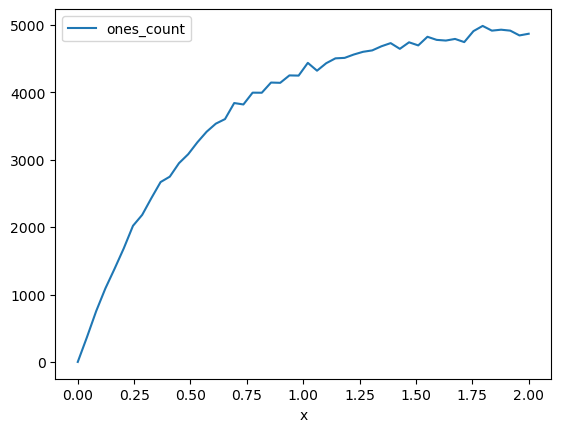

In [22]:
x_values = np.linspace(0., 2.)
ones_count = np.array([number_of_ones_after_time(x, 10000) for x in x_values])
pd.DataFrame({"x": x_values, "ones_count": ones_count}).plot(x="x", y="ones_count")

_Exercise: if we run this evolutionary process forever, then what is the fraction of 1s that will result in the sequence? Can you connect this with your answer to the question above using `matrix_power`?_

sequence_length / 2 --> 0.5 probability for each letter for each site

matrix power process converges in the same way

_Exercise: if we run this evolutionary process forever, how many mutations will happen? Contrast that with the answer to the previous question._

 an infinite number of mutations would occur

 mutations would not converge, whereas the fraction of 1s would

_Exercise: given your answer to the above, do you think it's easier to estimate the duration of relatively short periods of evolution versus very long ones?_

it is definitely easier to estimate the duration of relatively short periods of evolution  

_Exercise: say we observe a $\mu=1$ evolutionary process on a 0/1 sequence such that after some period of time `t`, 20% of the sites have changed from their original state. Using your plot above, give an "eyeball" estimate of `t`._

0.25 